In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import fftpack
from scipy import signal

Firstly, we download the datafile center_sternum.txt into a pandas dataframe . We consider every measurment taken every 0.005 s (frequency is 200 Hz). We decide to take care of the linear acceleration (in g), the angular velocity (in degree per second) and the magnetic field (in mgauss) in all three the directions. The quaternions are initially not considered, so we drop them. 

In [2]:
file_name="1_Stave_supine_static.txt"
data=pd.read_csv(file_name, "\t")

C:\Users\sacco\Downloads\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3369: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
freqs = data["Log Freq"].unique()
freq = np.bincount(freqs).argmax()
dt = 1.0/freq   #We controlled that every measure is 200 Hz and then calculate dt=1/200

initial_time=data.loc[0, "Timestamp"]
data["Abs Time"] = np.arange(len(data))*0.005
#for value, table in data.groupby("Timestamp"):    #We create a column of times
 #   data.loc[data["Timestamp"] == value, "Abs Time"] = value - initial_time + np.arange(0, len(table),1)/len(table)

labels=["GyroX", "GyroY", "GyroZ", "AccX", "AccY", "AccZ", "MagnX", "MagnY", "MagnZ"]
Nvar = len(labels)
data=data.drop(["Log Mode","qw", "qi", "qj", "qk"], axis=1)  #We drop this columns of data
data

,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Abs Time
0,100,1555487493,490.379,308.172,863.028,-40.73171,30.975610,45.853660,-642,-90,-83,0.000
1,100,1555487493,32.513,230.153,1015.406,23.90244,25.609760,40.731710,-177,-185,-321,0.005
2,100,1555487493,36.539,256.200,1012.051,-21.46342,3.780488,11.219510,-179,-185,-325,0.010
3,100,1555487493,65.331,241.194,1013.454,-30.24390,11.219510,6.341464,-180,-185,-325,0.015
4,100,1555487493,19.337,250.649,1004.121,-35.73171,12.926830,0.975610,-178,-182,-328,0.020
...,...,...,...,...,...,...,...,...,...,...,...,...
9165,100,1555487805,75.274,-682.590,664.778,34.14634,31.585370,-59.146340,-142,257,-480,45.825
9166,100,1555487805,131.760,-664.717,704.428,35.12195,21.097560,-68.292690,-138,255,-482,45.830
9167,100,1555487805,168.665,-679.479,751.581,36.70732,17.682930,-76.097560,-142,254,-479,45.835
9168,100,1555487805,204.472,-709.491,826.794,40.12195,18.170730,-87.195120,-139,253,-479,45.840


Now, we plot the accelerations and the angular velocity with respect to the time. In this way we have a first idea about the data, in particular we understand which windows of time is ideal to studying the dataset. We look for times where there's not anomalous variation of acceleration or velocity (maybe some movements of the body independent from the hearth rate, and respiration rate) that we do not want to consider. 

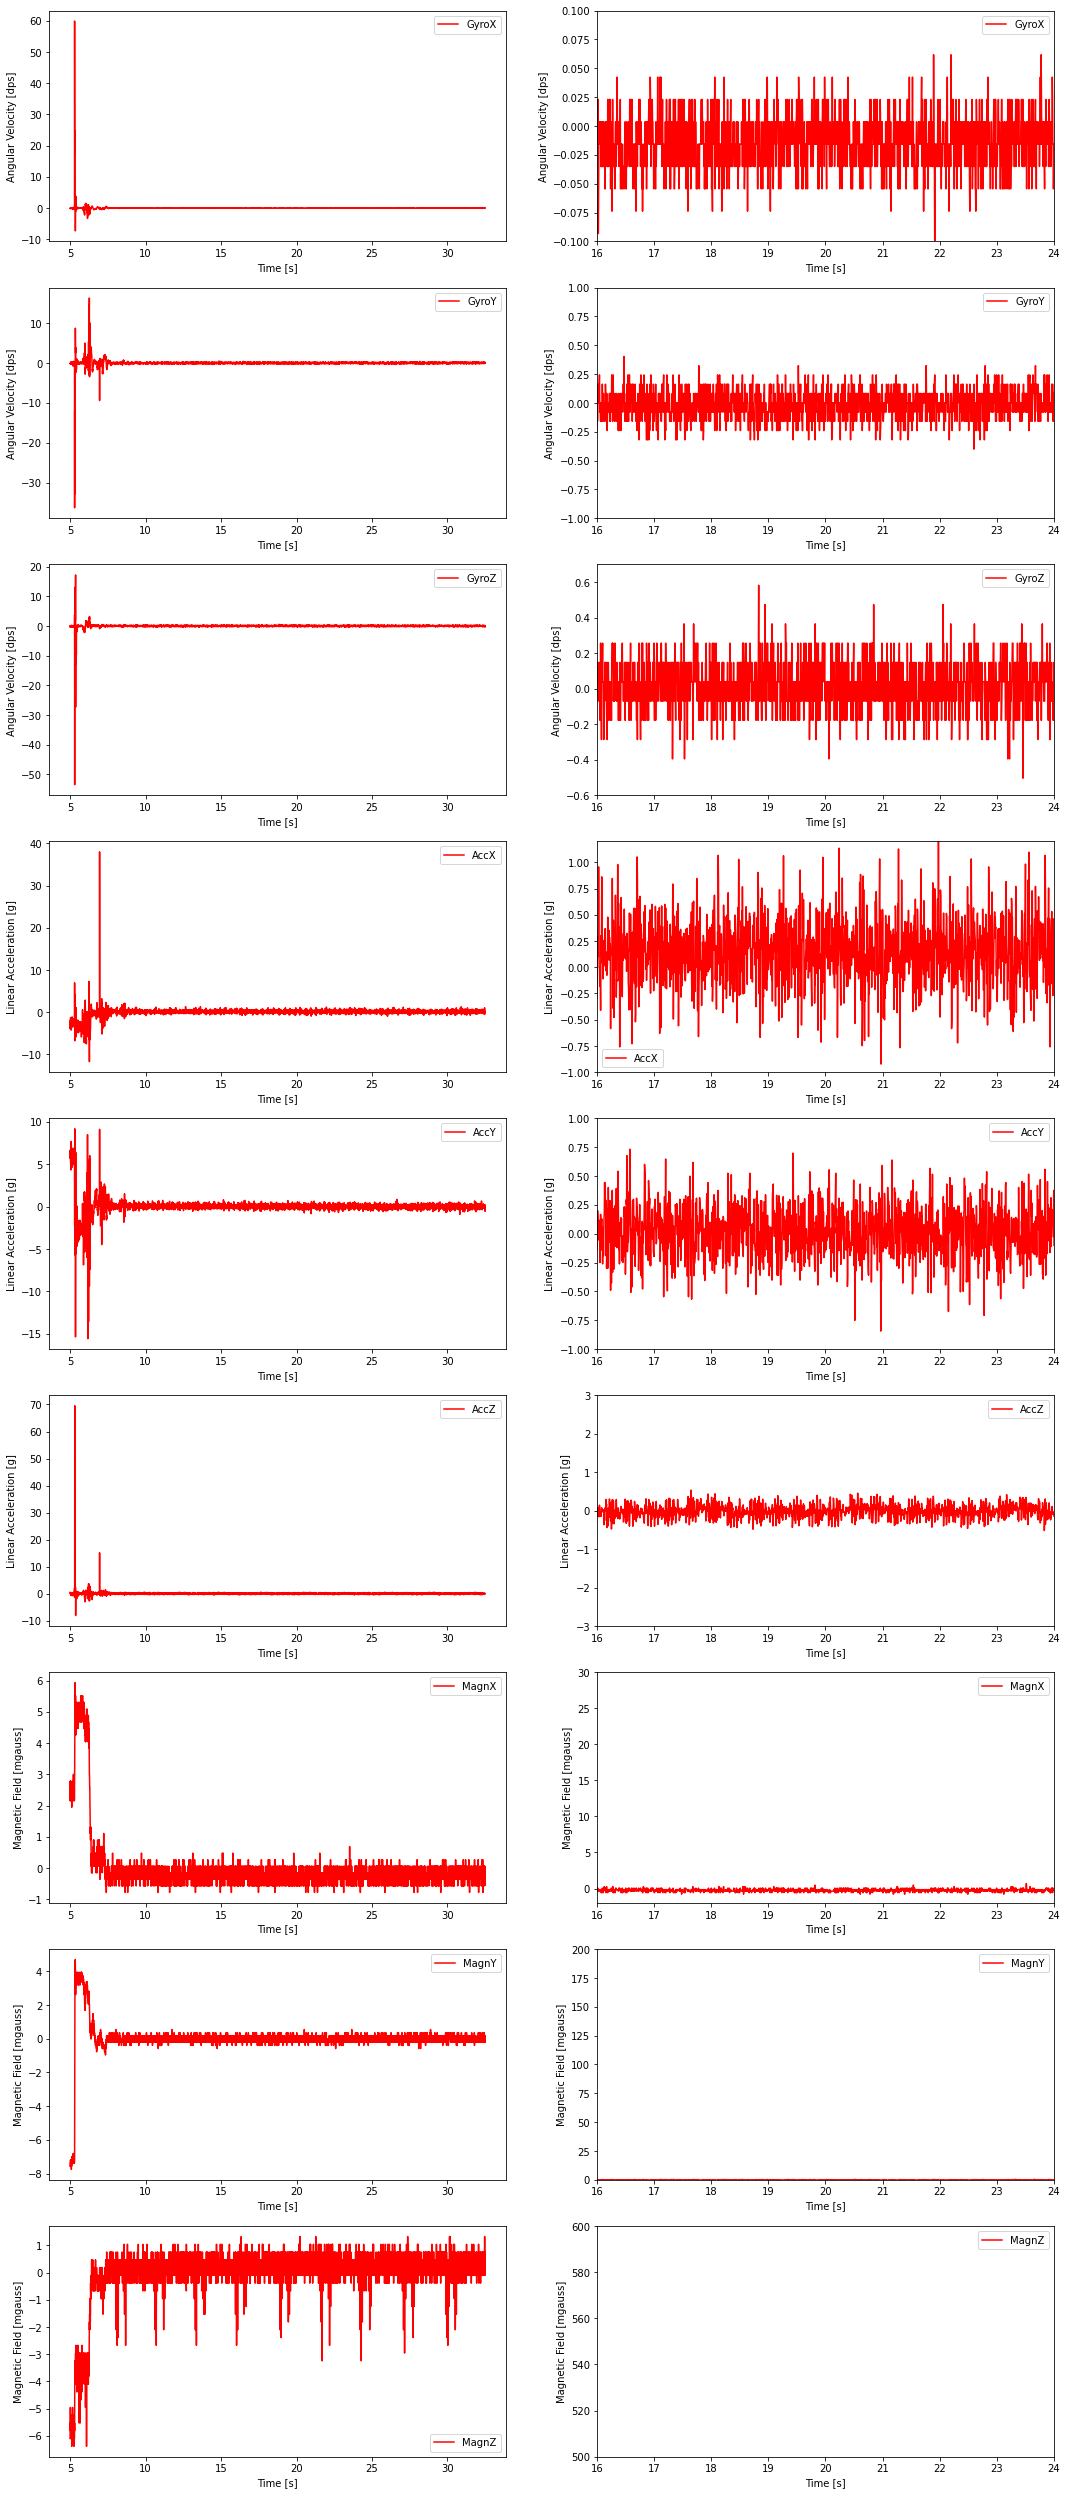

In [21]:
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,45))   #create a figure in which plotting the data

for i in range(2):
    for j in range(Nvar):
        axs[j][i].plot(data["Abs Time"], data[labels[j]], label=labels[j], c='r')
        if i == 1:
            axs[j][i].set_xlim([16,24])  #zoom in the right column to see a smaller window of time
        
axs[0][1].set_ylim([-0.1,0.1])
axs[1][1].set_ylim([-1,1])
axs[2][1].set_ylim([-0.6,0.7])
axs[3][1].set_ylim([-1,1.2])
axs[4][1].set_ylim([-1,1])
axs[5][1].set_ylim([-3,3])
axs[6][1].set_ylim([-2,30])
axs[7][1].set_ylim([0,200])
axs[8][1].set_ylim([500,600])

for i in range(2):
    for j in range(9):
        axs[j][i].set_xlabel("Time [s]")
        if j<3:
            axs[j][i].set_ylabel('Angular Velocity [dps]')
        elif j>5:
            axs[j][i].set_ylabel('Magnetic Field [mgauss]')
        else:
            axs[j][i].set_ylabel('Linear Acceleration [g]')
        axs[j][i].legend(loc="best")

Firstly, we see that from 10 seconds to 65 seconds all the measures have a constant behaviour, so we consider this to be the time window we're going to use in the rest of the project. Now we want to calculate some quantities to analyze these columns of data, mean, variance and correlations.

In [22]:
t1_cut = 10
t2_cut = 65   

#We select the time window over which performing the analysis

data = data.drop(data.index[range(t2_cut*freq,len(data))])
data = data.drop(data.index[range(t1_cut*freq)])
data

,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Abs Time
2000,100,1555487734,-0.133023,0.073730,-0.015019,-0.035093,-0.239674,0.365477,-0.152928,-0.019780,0.181431,10.000
2001,100,1555487734,0.049260,0.031243,0.330912,0.022997,-0.078897,-0.177946,-0.152928,-0.208321,0.181431,10.005
2002,100,1555487734,0.322685,-0.130206,0.235910,0.003633,0.001491,-0.069262,-0.362838,-0.019780,-0.104001,10.010
2003,100,1555487734,0.204960,-0.338390,0.015960,-0.054456,-0.078897,-0.069262,0.056981,-0.019780,0.181431,10.015
2004,100,1555487734,-0.797598,-0.028238,-0.181272,-0.015730,0.001491,-0.177946,-0.152928,0.168762,0.752296,10.020
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,100,1555487778,0.170782,-0.164195,-0.005725,-0.035093,-0.078897,0.039423,0.056981,-0.208321,0.181431,32.475
6496,100,1555487778,-0.015299,-0.185439,-0.051161,0.003633,0.162268,0.039423,-0.152928,-0.019780,0.466864,32.480
6497,100,1555487778,0.170782,-0.189687,-0.029475,-0.054456,0.001491,0.039423,-0.152928,-0.208321,-0.104001,32.485
6498,100,1555487778,-0.148214,-0.559321,-0.125510,-0.035093,0.081879,0.148108,-0.362838,-0.019780,0.752296,32.490


Now we print for all the columns remained the mean, standard deviation, minimum, maximum and the 25,50,75 percentiles in the time window we have selected

In [23]:
#get statistical descriptors 
data_stat = data.describe()
data_stat

,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Abs Time
count,4500.0,4.500000e+03,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000
mean,100.0,1.555488e+09,0.152150,0.013887,-0.016253,-0.014375,-0.014444,0.015102,-0.239738,-0.036246,0.236044,21.247500
std,0.0,1.277493e+01,0.286754,0.205927,0.164136,0.023712,0.121511,0.134574,0.188534,0.162468,0.382334,6.495912
min,100.0,1.555488e+09,-0.945703,-0.916208,-0.517909,-0.112546,-0.400451,-0.504000,-0.782656,-0.585405,-3.243759,10.000000
25%,100.0,1.555488e+09,-0.026691,-0.117460,-0.100727,-0.035093,-0.078897,-0.069262,-0.362838,-0.208321,-0.104001,15.623750
50%,100.0,1.555488e+09,0.155592,0.014248,-0.016051,-0.015730,0.001491,0.039423,-0.152928,-0.019780,0.181431,21.247500
75%,100.0,1.555488e+09,0.326483,0.150206,0.069657,0.003633,0.081879,0.148108,-0.152928,-0.019780,0.466864,26.871250
max,100.0,1.555488e+09,1.310053,0.851234,0.533307,0.061723,0.483820,0.582846,0.686709,0.545845,1.323161,32.495000


In [24]:
#set mean to zero to normalize the data
for l in labels:
    data[l]= (data[l]-data_stat.at["mean",l])/data_stat.at['std',l]

In [25]:
data.describe()

,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Abs Time
count,4500.0,4.500000e+03,4.500000e+03,4.500000e+03,4.500000e+03,4.500000e+03,4.500000e+03,4.500000e+03,4.500000e+03,4.500000e+03,4.500000e+03,4500.000000
mean,100.0,1.555488e+09,3.493502e-16,-2.823421e-16,3.155747e-16,3.324563e-15,-3.243825e-16,-3.228923e-15,4.232047e-14,1.224083e-14,-1.404753e-14,21.247500
std,0.0,1.277493e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.495912
min,100.0,1.555488e+09,-3.828551e+00,-4.516619e+00,-3.056350e+00,-4.140112e+00,-3.176733e+00,-3.857373e+00,-2.879687e+00,-3.380115e+00,-9.101471e+00,10.000000
25%,100.0,1.555488e+09,-6.236739e-01,-6.378313e-01,-5.146589e-01,-8.737518e-01,-5.304350e-01,-6.268931e-01,-6.529337e-01,-1.059139e+00,-8.893929e-01,15.623750
50%,100.0,1.555488e+09,1.200431e-02,1.756000e-03,1.228903e-03,-5.716356e-02,1.311381e-01,1.807277e-01,4.604432e-01,1.013493e-01,-1.428404e-01,21.247500
75%,100.0,1.555488e+09,6.079526e-01,6.619752e-01,5.234080e-01,7.594314e-01,7.927113e-01,9.883478e-01,4.604432e-01,1.013493e-01,6.037121e-01,26.871250
max,100.0,1.555488e+09,4.037966e+00,4.066230e+00,3.348208e+00,3.209196e+00,4.100582e+00,4.218829e+00,4.913951e+00,3.582814e+00,2.843370e+00,32.495000


We normalize the data by subtracting the mean and by dividing for the standard deviation. For the accelerations and the angular velocities the 25 and 75 percentiles are nearly simmetric, so the variables change quite regularly. We notice a higher deviation for the acceleration over X, and the angular velocity along Z 

Now, before performing a fourier analysis of the columns considered we would like to understand if there is some correlation between some of the variables

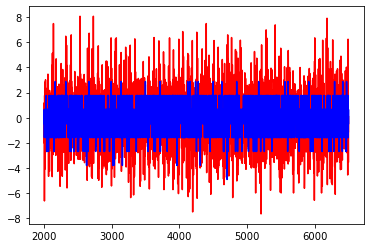

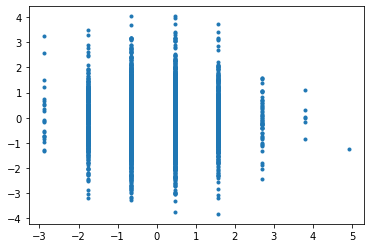

correlation between accX and magnX 
 [[ 1.         -0.00262808]
 [-0.00262808  1.        ]]

 correlation between accX and GyroY 
 [[1.         0.01448771]
 [0.01448771 1.        ]]

 correlation between accX and GyroZ 
 [[1.00000000e+00 4.99738258e-04]
 [4.99738258e-04 1.00000000e+00]]

 correlation between magnX and GyroY 
 [[1.         0.01409775]
 [0.01409775 1.        ]]

 correlation between magnX and GyroZ
 [[ 1.         -0.01907705]
 [-0.01907705  1.        ]]

 correlation between GyroZ and GyroY
 [[1.         0.03935583]
 [0.03935583 1.        ]]


In [26]:
plt.plot(2*data['AccX'], c='r')
#plt.plot(filtered[1], c='green')
#plt.plot(filtered[2], c='black')  
plt.plot(-data['MagnX'], c='b')
plt.show()
plt.plot(data['MagnX'], data['AccX'], '.')
plt.show()
print('correlation between accX and magnX \n',np.corrcoef(data['AccX'], y=data['MagnX']))
print('\n correlation between accX and GyroY \n',np.corrcoef(data['AccX'], y=data['GyroY']))
print('\n correlation between accX and GyroZ \n',np.corrcoef(data['AccX'], y=data['GyroZ']))
print('\n correlation between magnX and GyroY \n',np.corrcoef(data['MagnX'], y=data['GyroY']))
print('\n correlation between magnX and GyroZ\n',np.corrcoef(data['MagnX'], y=data['GyroZ']))
print('\n correlation between GyroZ and GyroY\n',np.corrcoef(data['GyroZ'], y=data['GyroY']))

The results are clearly not good

Now we're going to perform a fourier analysis using the scipy fftpack library; in this way we would like to estrapolate the principal frequencies of the data and see if we can see a frequence near the respiratory rate (and also the hearth rate frequency)

In [27]:
#perform Fourier analysis

sig_fft = 1j*np.zeros((Nvar, len(data)))

for i in range(Nvar):
    sig_fft[i] = fftpack.fft(data[labels[i]].values)

power = np.abs(sig_fft)
sample_freq = fftpack.fftfreq(len(data), d=dt)

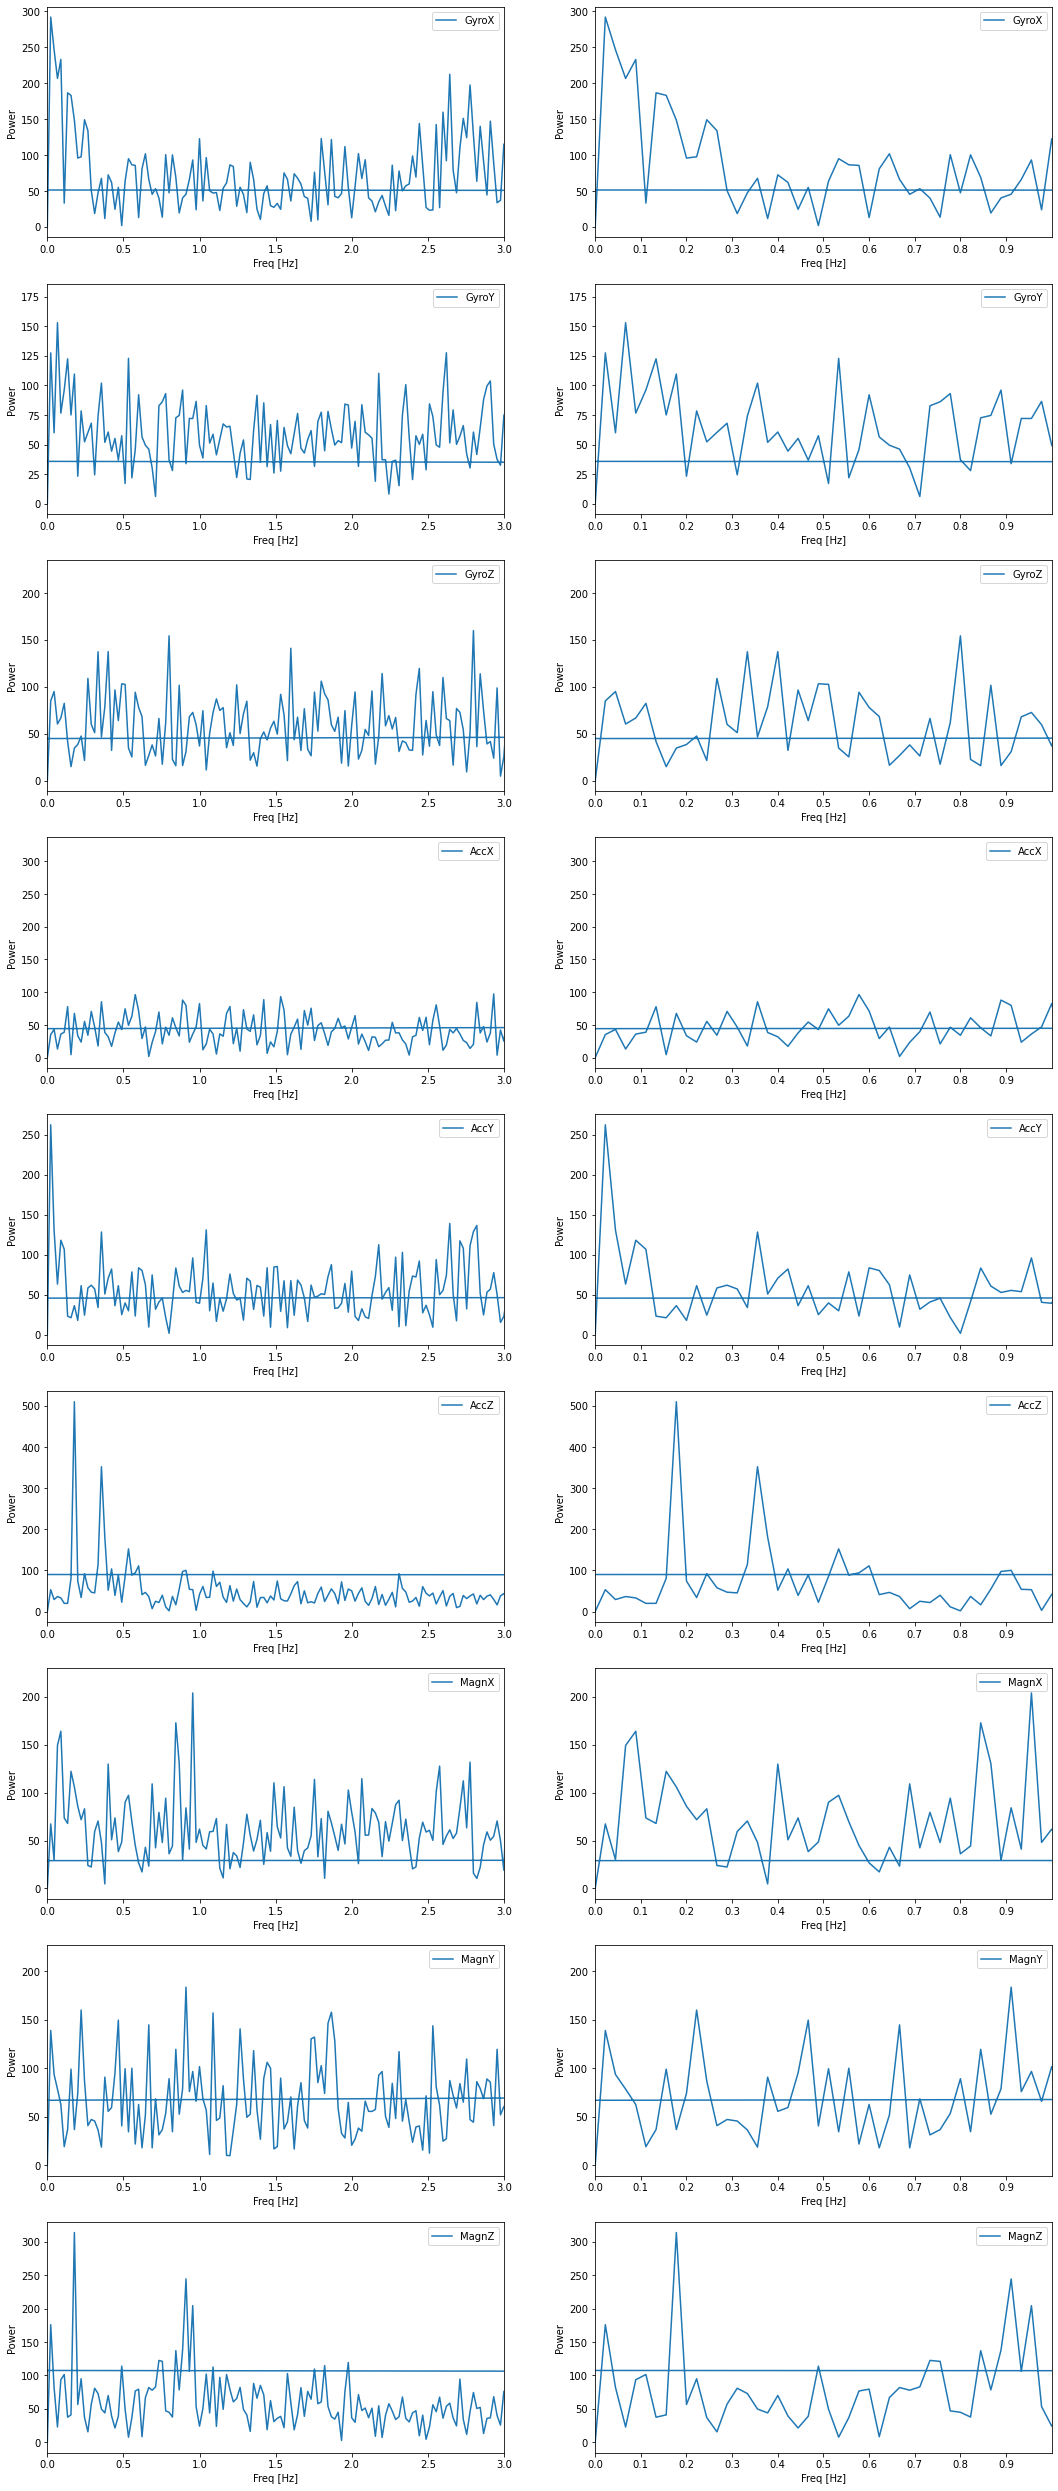

In [28]:
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,45))

for i in range(2):
    for j in range(Nvar):
        axs[j][i].plot(sample_freq, power[j], label=labels[j])
        if i == 0:
            axs[j][0].set_xlim([0,3])
        else:
            axs[j][i].set_xlim([0,1])
            axs[j][i].set_xticks(np.arange(0,1,0.1))
        

for ax in axs.flatten():
    ax.set_xlabel("Freq [Hz]")
    ax.set_ylabel("Power")
    ax.legend(loc="best")

In [36]:
#filter signal with Butterworth bandpass filter in [0.1,0.9] Hz range

filtered = np.zeros((Nvar,len(data)))
sos = signal.butter(2, [0.1,0.3], 'bandpass', fs=freq, output='sos')
for i in range(Nvar):
    filtered[i] = signal.sosfilt(sos, data[labels[i]])

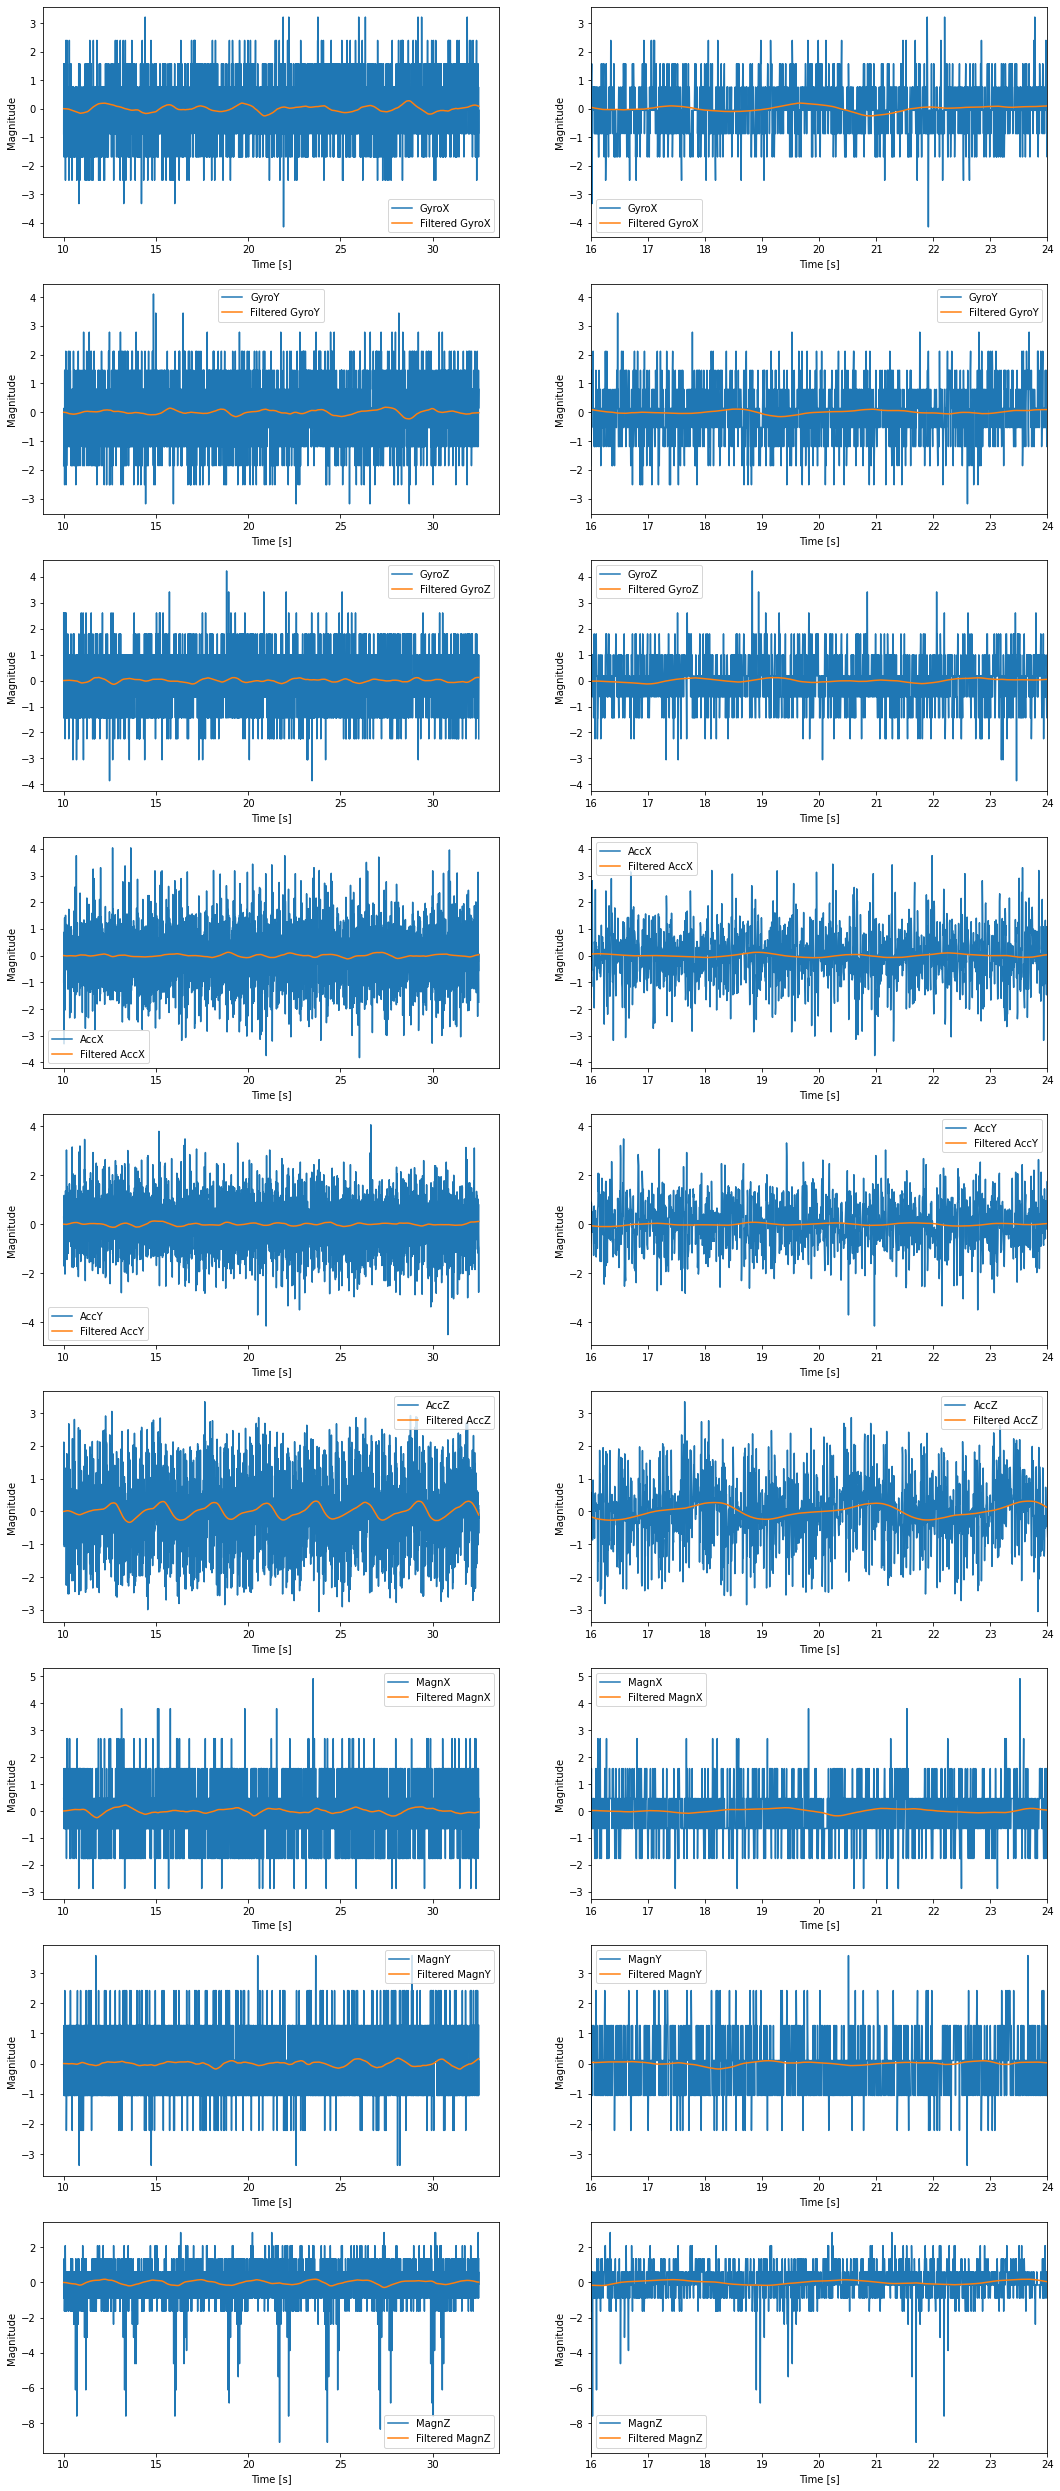

In [37]:
#plot filtered Gyro and Acc
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,45))

for i in range(2):
    for j in range(Nvar):
        axs[j][i].plot(data["Abs Time"], data[labels[j]], label=labels[j])
        axs[j][i].plot(data["Abs Time"], filtered[j],     label=("Filtered "+labels[j]))
        if i == 1:
            axs[j][i].set_xlim([16,24])

for ax in axs.flatten():
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Magnitude")
    ax.legend(loc="best")

Now , using the filtered signal we want again to test some correlation between the variables; in particular the linear acceleration and the magnetic field along X and the angular velocity in Y and Z

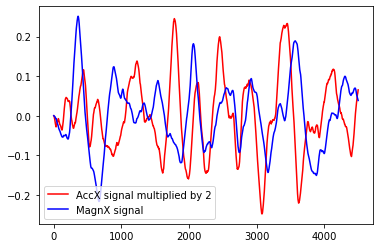

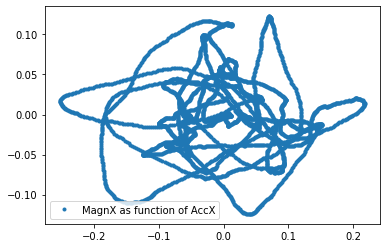

correlation between accX and magnX 
 [[ 1.         -0.01839529]
 [-0.01839529  1.        ]]

 correlation between accX and GyroY 
 [[1.         0.32304154]
 [0.32304154 1.        ]]

 correlation between accX and GyroZ 
 [[1.         0.06842511]
 [0.06842511 1.        ]]

 correlation between magnX and GyroY 
 [[ 1.         -0.07602775]
 [-0.07602775  1.        ]]

 correlation between magnX and GyroZ
 [[ 1.         -0.11288503]
 [-0.11288503  1.        ]]

 correlation between GyroZ and GyroY
 [[ 1.         -0.11027316]
 [-0.11027316  1.        ]]

 correlation between AccY and AccZ
 [[1.         0.04898968]
 [0.04898968 1.        ]]

 correlation between AccY and MagnZ
 [[1.         0.05892963]
 [0.05892963 1.        ]]

 correlation between AccZ and MagnZ
 [[1.         0.72557657]
 [0.72557657 1.        ]]


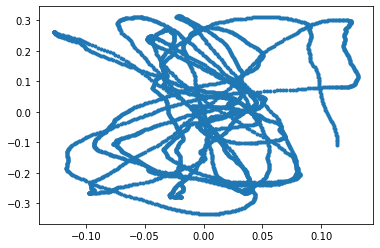

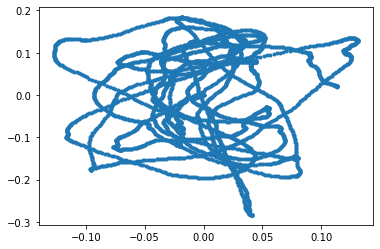

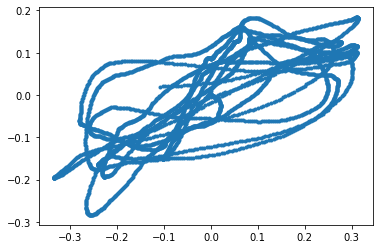

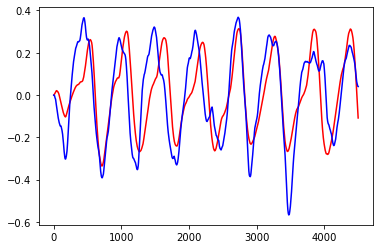

In [38]:
plt.plot(2*filtered[3], c='r', label='AccX signal multiplied by 2')
#plt.plot(filtered[1], c='green')
#plt.plot(filtered[2], c='black')
plt.plot(-filtered[6], c='b', label='MagnX signal')
plt.legend(loc='best')
plt.show()
plt.plot(filtered[6], filtered[3], '.', label='MagnX as function of AccX')
plt.legend(loc='best')
plt.show()

print('correlation between accX and magnX \n',np.corrcoef(filtered[3], y=filtered[6]))
print('\n correlation between accX and GyroY \n',np.corrcoef(filtered[3], y=filtered[1]))
print('\n correlation between accX and GyroZ \n',np.corrcoef(filtered[3], y=filtered[2]))
print('\n correlation between magnX and GyroY \n',np.corrcoef(filtered[6], y=filtered[1]))
print('\n correlation between magnX and GyroZ\n',np.corrcoef(filtered[6], y=filtered[2]))
print('\n correlation between GyroZ and GyroY\n',np.corrcoef(filtered[2], y=filtered[1]))
print('\n correlation between AccY and AccZ\n',np.corrcoef(filtered[4], filtered[5]))
print('\n correlation between AccY and MagnZ\n',np.corrcoef(filtered[4], filtered[8]))
print('\n correlation between AccZ and MagnZ\n',np.corrcoef(filtered[5], filtered[8]))

plt.plot(filtered[4], filtered[5], '.')
plt.show()
plt.plot(filtered[4], filtered[8], '.')
plt.show()
plt.plot(filtered[5], filtered[8], '.')
plt.show()

plt.plot(filtered[5], c='r')
plt.plot(filtered[8]*2, c='b')
plt.show()

We find a great correlation between magnX and accX (linear coefficient is -0.98). By the two plots we are also able to see a clear correlation between these two. They are the two cleanest signal so we would like to estimate the respiration rate by analyzing these two variables

The filtered signal has a regular behaviour (oscillating) for the acceleration only in the X direction (we think about it as the direction that goes through the body), for the angular velocity along Y and for the magnetic field we find a regular oscillation in the X direction

In [39]:
#plot filtered spectrum
sig_fft_new = 1j*np.zeros((Nvar, len(data)))

for i in range(Nvar):
    sig_fft_new[i] = fftpack.fft(filtered[i])

power_new = np.abs(sig_fft_new)

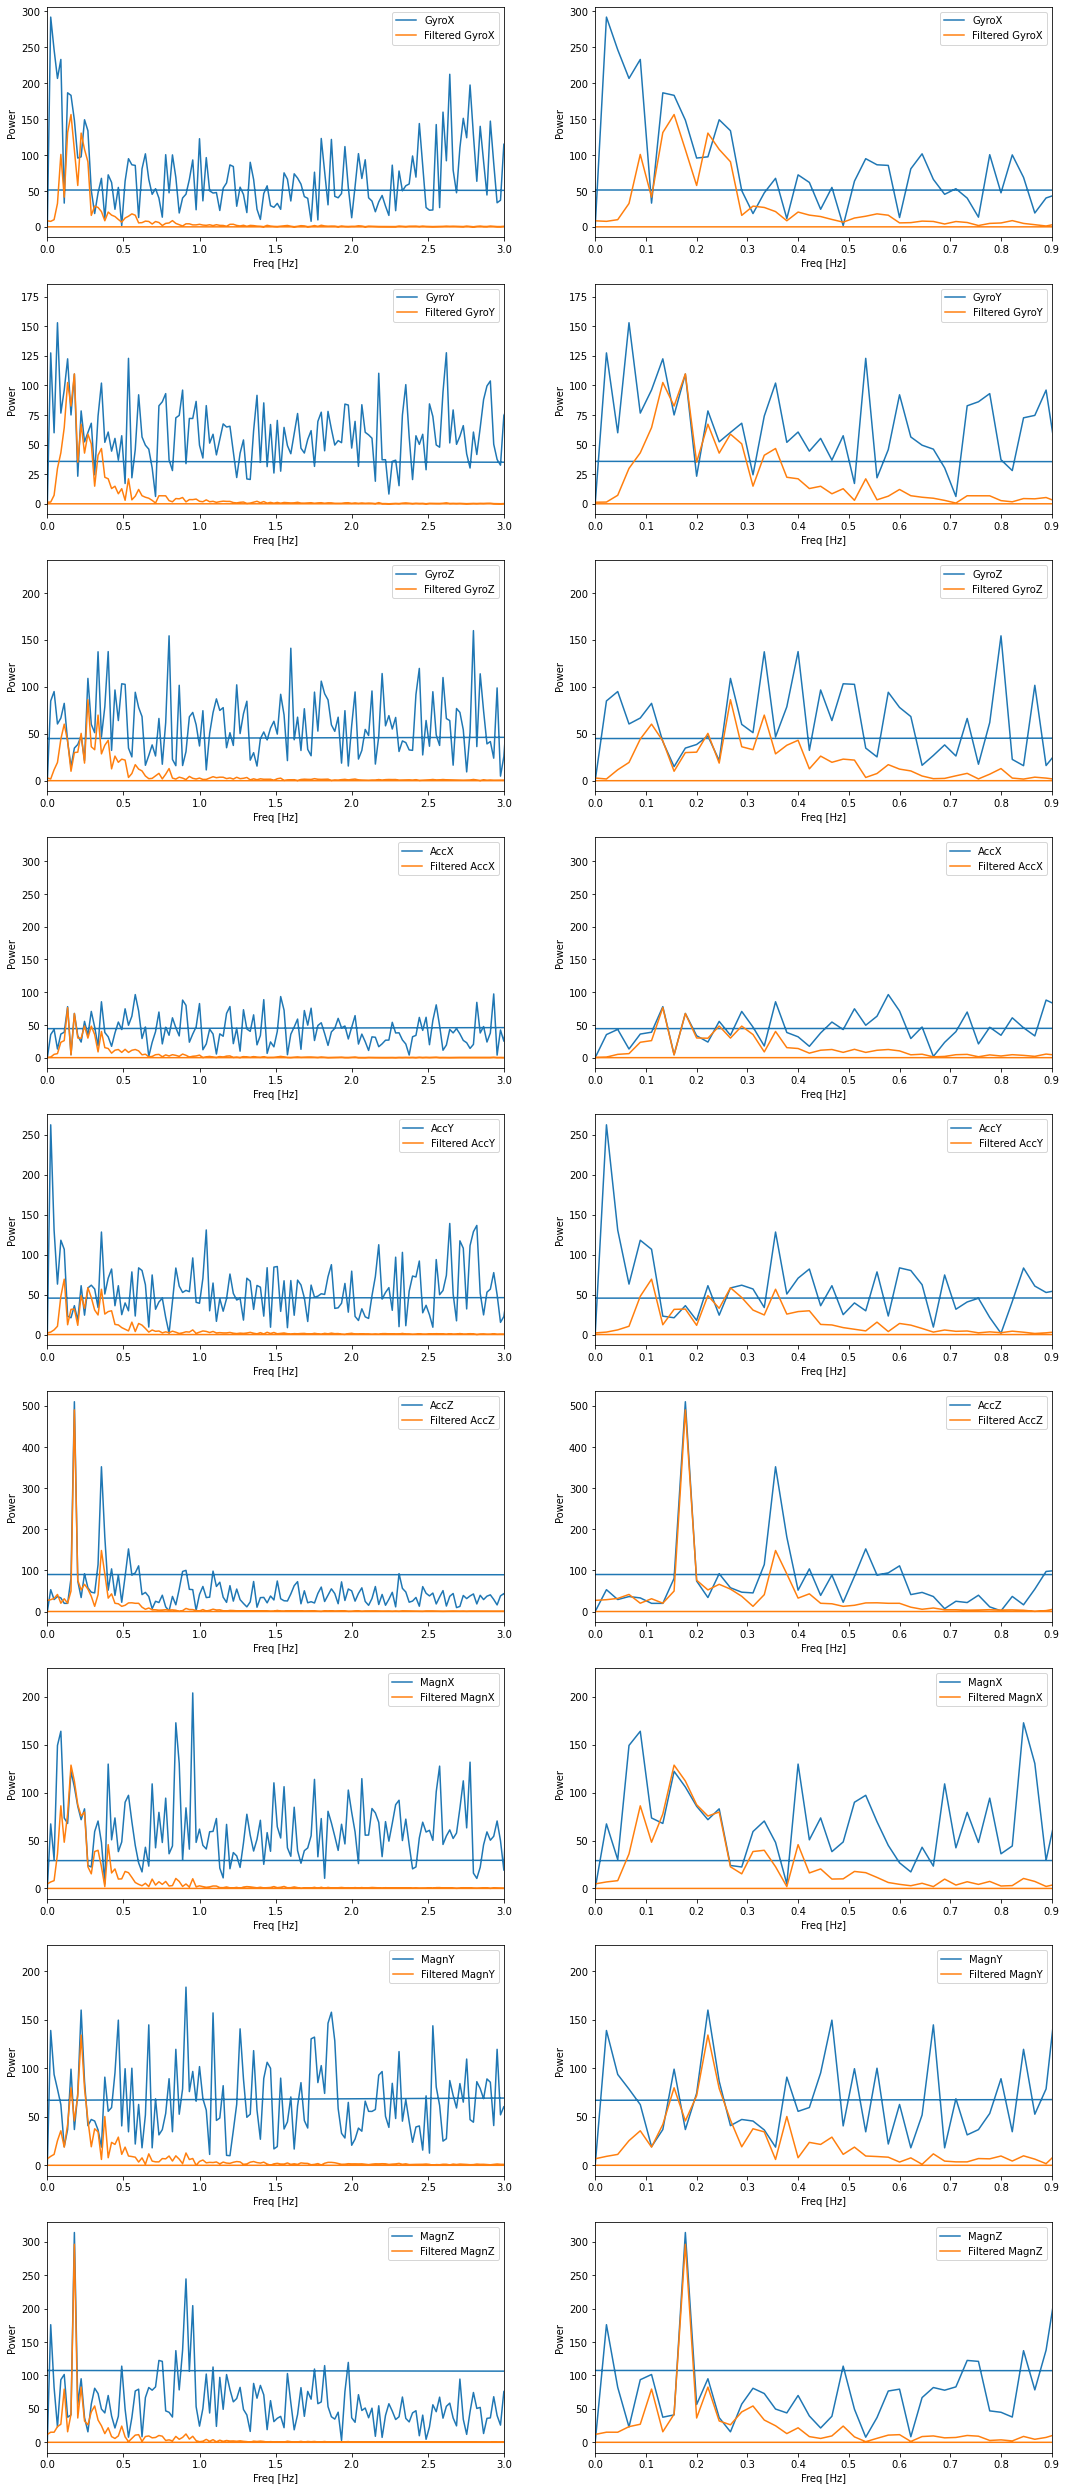

In [40]:
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,45))

for i in range(2):
    for j in range(Nvar):
        axs[j][i].plot(sample_freq, power[j],     label=labels[j])
        axs[j][i].plot(sample_freq, power_new[j], label=("Filtered "+labels[j]))
        if i == 0:
            axs[j][0].set_xlim([0,3])
        else:
            axs[j][i].set_xlim([0,0.8])
            axs[j][i].set_xticks(np.arange(0,1,0.1))
        

for ax in axs.flatten():
    ax.set_xlabel("Freq [Hz]")
    ax.set_ylabel("Power")
    ax.legend(loc="best")

We see well the hearth frequence, near 1.2 Hz in almost all the plots. For the respiration rate we see some possible result (the rate is about 12 RPM, so a frequency near 0.2 Hz) in the angular velocities in Y (in particular) and Z. In the acceleration along X is quite evident a peak between 0.1 and 0.2 Hz. Also in the magnetic field along X we see a high peak in that frequency. We can try to estimate the rate by picking the power maximum of the frequencies in a certain window (let's say {0.1,0.3}). 